## ML - Previsão de Churn

##### Esse modelo será treinado com três anos de dados, incluindo um dataset com informações dos clientes e um dataset com informações das compras.
##### O método utilizado será árvore aleatória e o resultado deve ser churn(1,0), indicando se o cliente abandonará a empresa em até um ano.

In [16]:
import pandas as pd
import numpy as np

##### Importação de colunas relevantes. O DF já foi tratado em outro script

In [17]:
df= pd.read_csv('df_clientes_vendas.csv', sep=',', usecols=['codigo', 'venda', 'dia_da_semana', 'turno',
       'tipo_do_item', 'grupo', 'liquido',
       'situacao_no_ciclo_de_vida',
       'tempo_de_relacionamento', 'sexo', 'animais_vivos'])

##### Formatação para utilização no aprendizado de máquina

In [18]:
# Agrupamento do DF para gerar lista de clientes. Soma de vendas e líquido.
df_clientes = df.groupby('codigo').agg({
    'venda': 'count',  # Número total de compras
    'liquido': 'sum',  # Receita total gerada
    'sexo': 'first',  # Assumindo que o sexo não muda
    'tempo_de_relacionamento': 'first',
    'animais_vivos': 'first',
    'situacao_no_ciclo_de_vida': 'first'
})

# Cálculo de ticket médio
df_clientes['ticket_medio'] = df_clientes['liquido'] / df_clientes['venda']
df_clientes['ticket_medio'] = np.round(df_clientes['ticket_medio'],2)


# Aplicar mode() separadamente para cada coluna categórica
for col in ['dia_da_semana', 'turno', 'tipo_do_item', 'grupo']:
    df_clientes[col] = df.groupby('codigo')[col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)

df_clientes.reset_index(inplace=True)

# Binarização da coluna de churn / clientes ativos = última compra em menos de um ano
df_clientes['situacao_no_ciclo_de_vida'] = df_clientes['situacao_no_ciclo_de_vida'].apply(lambda x: 0 if x == 'clientes ativos' else 1)
df_clientes['churn'] = df_clientes.pop('situacao_no_ciclo_de_vida')

# Criando um dicionário para conversão da coluna de tempo de relacionamento
tempo_map = {
    '1 a 3 meses': 0.17, 
    '3 a 6 meses': 0.375, 
    '6 meses a 1 ano': 0.75, 
    '1 a 2 anos': 1.5, 
    '2 a 3 anos': 2.5, 
    '3 a 5 anos': 4, 
    'acima de 5 anos': 6
}

# Aplicando a conversão
df_clientes['tempo_de_relacionamento'] = df_clientes['tempo_de_relacionamento'].map(tempo_map)
df_clientes = df_clientes.dropna()

# Binarização da coluna sexo e tipo do item
df_clientes['sexo'] = df_clientes.sexo.apply(lambda x: 0 if x != 'feminino' else 1)
df_clientes['sexo'].value_counts()

df_clientes.tipo_do_item = df_clientes.tipo_do_item.apply(lambda x: 1 if x.strip() == 'serviço' else 0)
df_clientes

,codigo,venda,liquido,sexo,tempo_de_relacionamento,animais_vivos,ticket_medio,dia_da_semana,turno,tipo_do_item,grupo,churn
0,1.0,84,4812.37,1,6.00,4.0,57.29,terça-feira,manha,0,vacinação,0
1,2.0,34,2270.90,0,6.00,1.0,66.79,sábado,manha,0,farmácia,1
2,3.0,121,6978.28,0,6.00,2.0,57.67,segunda-feira,manha,0,exame laboratorial,0
3,4.0,10,932.00,0,6.00,1.0,93.20,quarta-feira,manha,0,vacinação,0
4,5.0,487,28287.36,0,6.00,9.0,58.08,quarta-feira,manha,0,material hospitalar i,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,4063.0,6,133.50,1,0.17,1.0,22.25,sábado,tarde,0,material hospitalar i,0
1088,4065.0,11,408.50,0,0.17,0.0,37.14,domingo,tarde,0,material hospitalar i,0
1089,4066.0,8,300.40,0,0.17,1.0,37.55,quinta-feira,tarde,1,material hospitalar i,0
1090,4067.0,3,121.80,1,0.17,1.0,40.60,segunda-feira,manha,0,farmácia,0


In [ ]:
# Excluir coluna código
df_clientes.pop('codigo')


In [20]:
# One-Hot Encoding para categorias
df_c = pd.get_dummies(df_clientes, columns=['dia_da_semana', 'turno', 'grupo'])
df_c

,venda,liquido,sexo,tempo_de_relacionamento,animais_vivos,ticket_medio,tipo_do_item,churn,dia_da_semana_domingo,dia_da_semana_quarta-feira,...,grupo_internamento,grupo_material hospitalar i,grupo_medicamentos hospitalares,grupo_procedimentos,grupo_ração úmida,grupo_roupas,grupo_serviço de terceiros,grupo_tosa,grupo_tosa higienica,grupo_vacinação
0,84,4812.37,1,6.00,4.0,57.29,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
1,34,2270.90,0,6.00,1.0,66.79,0,1,False,False,...,False,False,False,False,False,False,False,False,False,False
2,121,6978.28,0,6.00,2.0,57.67,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10,932.00,0,6.00,1.0,93.20,0,0,False,True,...,False,False,False,False,False,False,False,False,False,True
4,487,28287.36,0,6.00,9.0,58.08,0,0,False,True,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,6,133.50,1,0.17,1.0,22.25,0,0,False,False,...,False,True,False,False,False,False,False,False,False,False
1088,11,408.50,0,0.17,0.0,37.14,0,0,True,False,...,False,True,False,False,False,False,False,False,False,False
1089,8,300.40,0,0.17,1.0,37.55,1,0,False,False,...,False,True,False,False,False,False,False,False,False,False
1090,3,121.80,1,0.17,1.0,40.60,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


# Modelo

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import GridSearchCV

In [22]:
# Separar features e target
X = df_c.drop(columns='churn')  # Remover ID e target
y = df_c['churn']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Busca de hiperparâmetros

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"\nMelhores parâmetros: {best_params}")

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=

In [ ]:
#
# Melhores parâmetros: {'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
#

# Treinar um modelo de Random Forest
clf = RandomForestClassifier(**best_params)
#**best_params
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=40, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=300)

##### Validação cruzada

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {scores.mean()}")

Acurácia média da validação cruzada: 0.8027651888341543


##### Matriz de confusão

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred = clf.predict(X_test)
print("Matriz de confusão:\n")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de classificação:\n")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")

Matriz de confusão:

[[94 21]
 [16 88]]

Relatório de classificação:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       115
           1       0.81      0.85      0.83       104

    accuracy                           0.83       219
   macro avg       0.83      0.83      0.83       219
weighted avg       0.83      0.83      0.83       219

AUC-ROC: 0.9069397993311037


##### Feature importance

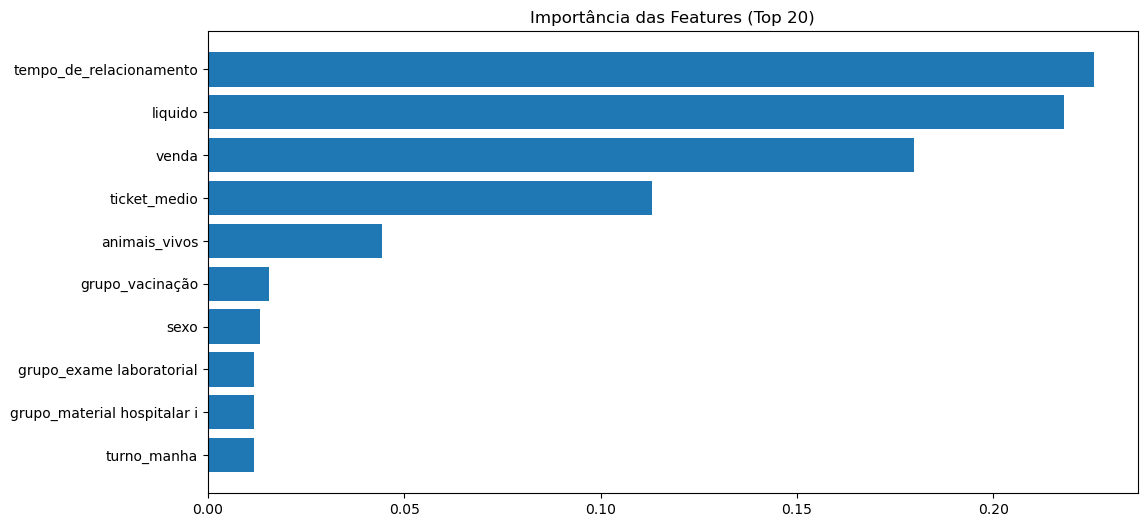

In [40]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleciona as 20 primeiras características
top_n = 10
indices_top_n = indices[:top_n]

plt.figure(figsize=(12, 6))
plt.title("Importância das Features (Top 20)")
plt.barh(range(top_n), importances[indices_top_n], align="center")
plt.yticks(range(top_n), X_train.columns[indices_top_n])
plt.gca().invert_yaxis()  # Inverte a ordem para que a feature mais importante esteja no topo
plt.show()

##### Curva de aprendizado

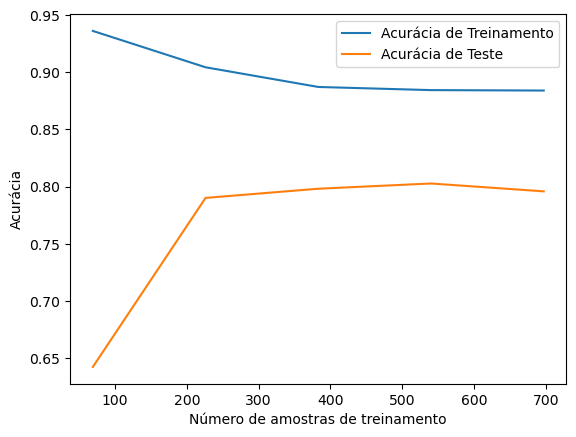

In [36]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Acurácia de Treinamento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Acurácia de Teste")
plt.xlabel("Número de amostras de treinamento")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

##### Árvore

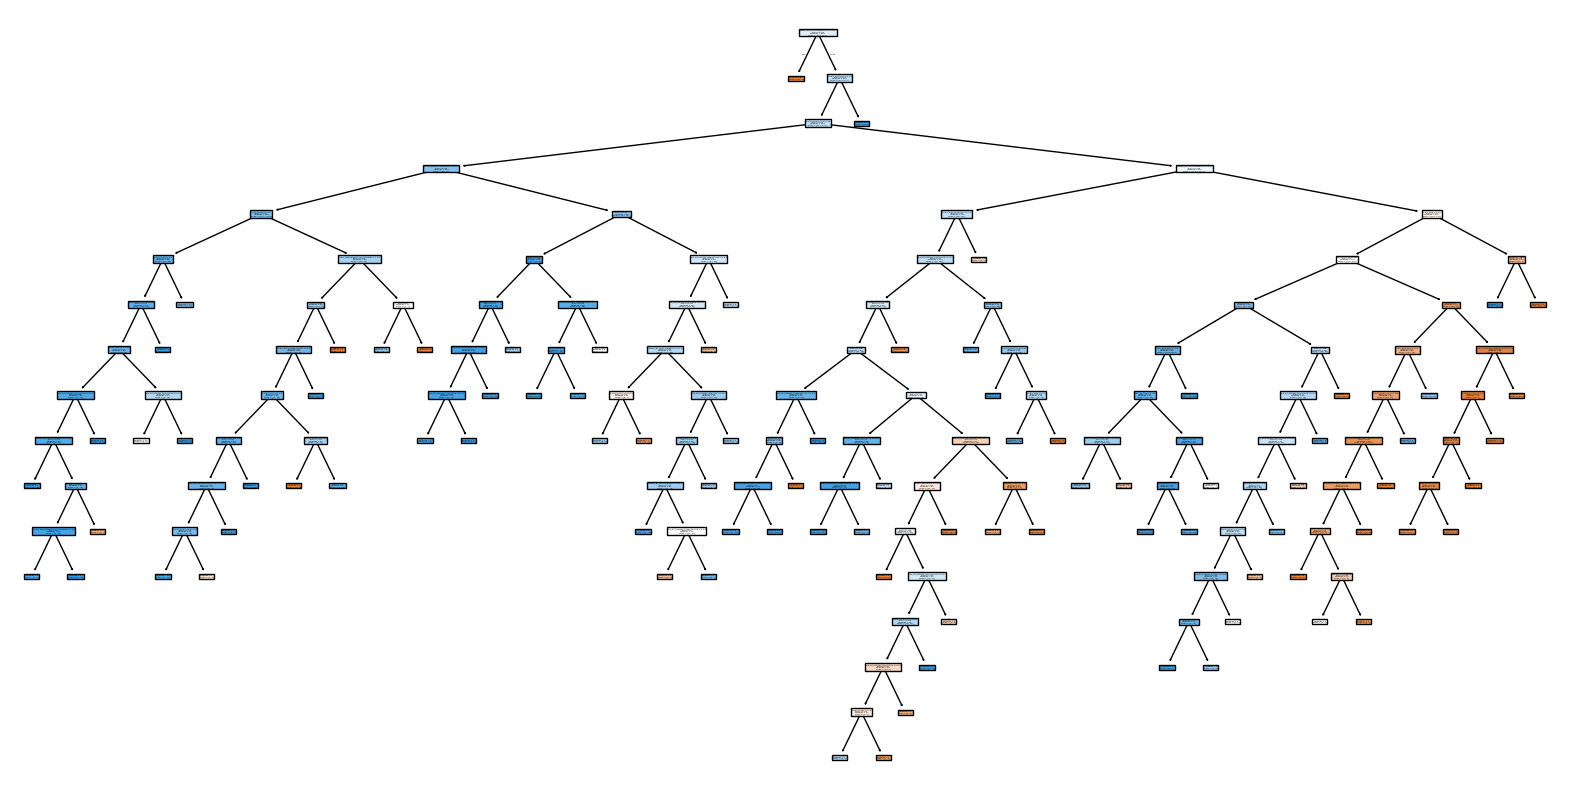

|--- tempo_de_relacionamento <= 1.12
|   |--- class: 0.0
|--- tempo_de_relacionamento >  1.12
|   |--- grupo_anestesia <= 0.50
|   |   |--- ticket_medio <= 49.74
|   |   |   |--- grupo_material hospitalar i <= 0.50
|   |   |   |   |--- turno_tarde <= 0.50
|   |   |   |   |   |--- turno_noite <= 0.50
|   |   |   |   |   |   |--- ticket_medio <= 45.18
|   |   |   |   |   |   |   |--- grupo_banho <= 0.50
|   |   |   |   |   |   |   |   |--- dia_da_semana_terça-feira <= 0.50
|   |   |   |   |   |   |   |   |   |--- tempo_de_relacionamento <= 3.25
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- tempo_de_relacionamento >  3.25
|   |   |   |   |   |   |   |   |   |   |--- liquido <= 2756.85
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- liquido >  2756.85
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- dia_da_semana_terça-

In [38]:
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# Escolhe uma árvore da floresta (a primeira, por exemplo)
tree = clf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train.columns, filled=True)
plt.show()

# Get decision rules in text format
tree_rules = export_text(tree, feature_names=list(X_train.columns))

print(tree_rules)
with open("tree_rules.txt", "w") as f:
    f.write(tree_rules)

print("Tree rules saved to tree_rules.txt")

##### Exportação

In [39]:
import joblib
# Salvando com joblib
joblib.dump(clf, 'modelo_churn.pkl')

['modelo_churn.pkl']